In [35]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

pi = np.pi
c = 3.0e10  # cm/s
fac = 3.08567758e21 #unit conversion 
# Parameters
K0 = 3e27
alpha = 0.6
C = 3.0 ** 0.6
tau = 1e16
L = 4.0 * fac  # cm
R = 20.0 * fac  # cm
mchi = 2000.0  # GeV
sigmaV_WW = 1.6e-23
sigmaV_ZZ = 3e-25
r_solar = 8.5 * fac  # cm
z_solar = 0.0 * fac # cm
N_r = 50 #r grid
N_z = 50 #z grid
N = 10
M = 10

In [36]:
# Fragmentation functions from the paper. Can add other fragmentation functions here as well especially for low m_chi
def f_WW(x):
    ln_x = np.log(x)
    WW = (
        -2.28838
        - 0.605364 * ln_x
        - 0.287614 * ln_x**2
        - 0.762714 * ln_x**3
        - 0.319561 * ln_x**4
        - 0.0583274 * ln_x**5
        - 0.00503555 * ln_x**6
        - 0.00016691 * ln_x**7
    )
    return np.exp(WW)

def f_ZZ(x):
    ln_x = np.log(x)
    ZZ = (
        -2.75588
        - 0.45725 * ln_x
        - 0.141373 * ln_x**2
        - 0.905392 * ln_x**3
        - 0.444098 * ln_x**4
        - 0.0936451 * ln_x**5
        - 0.00942148 * ln_x**6
        - 0.000369777 * ln_x**7
    )
    return np.exp(ZZ)

#f_WW(0.1)
#f_ZZ(0.1)

In [37]:
# Dark matter density profile as in the paper
def rho(r, z):
    Rc = 2.8 * fac #core radius of galaxy
    r_gc = np.sqrt(r * r + z * z) #distance from galactic center
    rho0 = 0.43 #local halo density
    num = Rc * Rc + r_solar * r_solar
    denom = Rc * Rc + r_gc * r_gc
    return rho0 * num / denom


In [53]:
# Preparing the zeros of Bessel function J0
zeta = sp.jn_zeros(0, N)

#zeta

In [39]:
# Preparing the z and r grids for midpoint integration 
dr = R / N_r
dz = 2 * L / N_z #since z from -L to L

r = []
for i in range(N_r):
    r_i = (i + 0.5) * dr
    r.append(r_i)
r = np.array(r)

z = []
for j in range(N_z):
    z_j = -L + (j + 0.5) * dz #starting from -L
    z.append(z_j)
z = np.array(z)

#dr
#dz
#r
#z

In [40]:
# Computing the Bessel and sine functions on the grid
J0_vals = np.zeros((N_r, N))
for i in range(N_r):
    for n in range(1, N + 1):  # Starting n from 1
        arg = zeta[n - 1] * r[i] / R  # zeta[n-1] to access the correct zero
        J0_vals[i, n - 1] = sp.j0(arg)  # Store in zero-based index (othersie we get errors)


sin_vals = np.zeros((N_z, M))
for j in range(N_z):
    for m in range(1, M + 1):  # Starting m from 1
        arg = m * pi * (z[j] - L) / (2 * L)  
        sin_vals[j, m - 1] = np.sin(arg)  # Store in zero-based index

#J0_vals
#sin_vals

In [41]:
# Computing the Dark matter number density on teh grid
rho_grid = np.zeros((N_r, N_z))
for i in range(N_r):
    for j in range(N_z):
        rho_grid[i, j] = rho(r[i], z[j])

n_chi_grid = rho_grid / mchi #divided by Dark matter mass

#n_chi_grid

In [42]:
# Energy grid after experimentation, we need more grid values for low energy range
epsilon_min = 1.0
epsilon_mid = 120.0 #more grid points between 1 and 120 GeV
epsilon_max = mchi

deltaE_low = 1 #space between grid points in the low energy region
N_eps_low = int((epsilon_mid - epsilon_min) / deltaE_low) + 1
N_eps_high = 200 #number of steps after 120 GeV
deltaE_high = (epsilon_max - epsilon_mid) / (N_eps_high - 1)

eps_low = []
for i in range(N_eps_low):
    eps_i = epsilon_min + i * deltaE_low
    eps_low.append(eps_i)

eps_high = []
for i in range(1, N_eps_high):
    eps_i = epsilon_mid + i * deltaE_high
    eps_high.append(eps_i)

E = np.array(eps_low + eps_high) #energy grid combining low and high ranges

#E

In [43]:
# Positron production spectrum
def dN_dE(eps):
    x = eps / mchi
    if x <= 0 or x >= 1:
        return 0.0
    dNdx_WW = sigmaV_WW * f_WW(x) #multiplied by \simga*v, will change location later
    dNdx_ZZ = sigmaV_ZZ * f_ZZ(x) #multiplied by \simga*v, will change location later
    return (dNdx_WW + dNdx_ZZ) / mchi  # divided by DM mass

#dN_dE(2)

In [44]:
# Q_mn(epsilon). This takes a few minutes. Might change method later or replace for loops to make faster.
Qmn = np.zeros((len(E), M, N))
for k in range(len(E)):
    eps = E[k]
    dNdE = dN_dE(eps)
    for n in range(1, N + 1):
        J1_zeta_n = sp.j1(zeta[n - 1])
        norm = 2.0 / (J1_zeta_n * J1_zeta_n * R * R * L)
        for m in range(1, M + 1):
            integrand = np.zeros((N_r, N_z)) #Here I use the midpoint method for integration on the r and z grid
            for i in range(N_r):
                for j in range(N_z):
                    J0 = J0_vals[i, n - 1]
                    sin_m = sin_vals[j, m - 1]
                    n_chi_sq = n_chi_grid[i, j] * n_chi_grid[i, j]
                    integrand[i, j] = 0.5 * n_chi_sq * dNdE * J0 * sin_m * r[i] #later I will bring \sigma*v here and sum. now they are inside dN_dE.
            integral = np.sum(integrand) * dr * dz
            Qmn[k, m - 1, n - 1] = integral * norm

#Q[2, 5, 5]
#Qmn

In [45]:
# A_mn(epsilon) 
Amn = np.zeros((len(E), M, N))
for i in range(len(E)):
    eps = E[i]
    eps_sq = eps * eps
    for n in range(1, N + 1):
        for m in range(1, M + 1):
            eps_p = E[i:] #starting from grid points where eps_p > eps 
            Qmn_p = Qmn[i:, m - 1, n - 1] #bringing corresponding values 
            kappa = (zeta[n - 1] / R) ** 2 + (m * pi / (2 * L)) ** 2
            Lambda = kappa * K0 * tau * (
                -C * (1.0 / eps - 1.0 / eps_p)
                + (eps ** (alpha - 1) - eps_p ** (alpha - 1)) / (alpha - 1)
            )
            integrand = (tau * Qmn_p / eps_sq) * np.exp(Lambda)
            integral = np.trapz(integrand, eps_p) #here I use the Trapezoidal method for integration on E grid
            Amn[i, m - 1, n - 1] = integral

#Amn

In [46]:
# Positron distribution at Earth
f_ep = []
for i in range(len(E)):
    s = 0.0
    for n in range(1, N + 1):
        J0_val = sp.j0(zeta[n - 1] * r_solar / R)
        for m in range(1, M + 1):
            sin_val = np.sin(m * pi * (z_solar - L) / (2 * L)) 
            s += Amn[i, m - 1, n - 1] * J0_val * sin_val
    f_ep.append(s)

f_ep = np.array(f_ep)
phi_e_plus_signal = (c / (4.0 * pi)) * f_ep

#f_ep
#phi_e_plus_signal

In [47]:
# Background fluxes from the paper
def phi_e_minus_prim(E):
    return 0.16 * E ** (-1.1) / (1.0 + 11.0 * E ** 0.9 + 3.2 * E ** 2.15)

def phi_e_minus_sec(E):
    return 0.70 * E ** 0.7 / (1.0 + 110.0 * E ** 1.5 + 600.0 * E ** 2.9 + 580.0 * E ** 4.2)

def phi_e_plus_sec(E):
    return 4.5 * E ** 0.7 / (1.0 + 650.0 * E ** 2.3 + 1500.0 * E ** 4.2)

phi_e_plus_sec_array = phi_e_plus_sec(E)
phi_e_minus_prim_array = phi_e_minus_prim(E)
phi_e_minus_sec_array = phi_e_minus_sec(E)


In [48]:
# Total positron and electron fluxes
phi_e_plus_total = phi_e_plus_signal + phi_e_plus_sec_array
phi_e_minus_total = phi_e_minus_prim_array + phi_e_minus_sec_array

# Positron fraction
positron_fraction = phi_e_plus_total / (phi_e_plus_total + phi_e_minus_total)

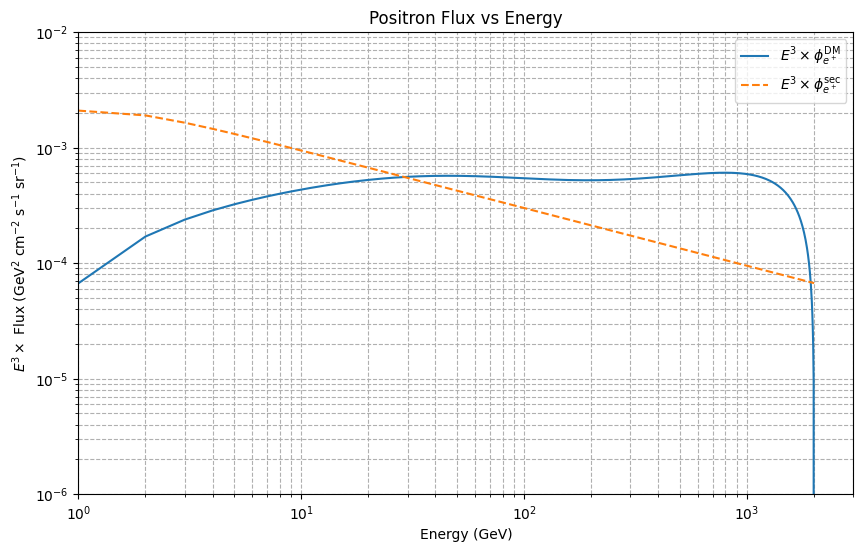

In [49]:
# Plotting E^3 * Flux
plt.figure(figsize=(10, 6))
plt.loglog(E, E ** 3 * phi_e_plus_signal, label=r'$E^3 \times \phi_{e^+}^{\text{DM}}$')
plt.loglog(E, E ** 3 * phi_e_plus_sec_array, linestyle='--', label=r'$E^3 \times \phi_{e^+}^{\text{sec}}$')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^3 \times$ Flux (GeV$^{2}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.title('Positron Flux vs Energy')
plt.legend()
plt.grid(True, which="both", ls="--") #show grid
plt.xlim([1, 3000]) #as in the paper
plt.ylim([1e-6, 1e-2]) #as in the paper
plt.show()

In [50]:
# Background positron fraction
phi_e_plus_background = phi_e_plus_sec_array
phi_e_minus_background = phi_e_minus_prim_array + phi_e_minus_sec_array
phi_e_total_background = phi_e_plus_background + phi_e_minus_background
background_positron_fraction = phi_e_plus_background / phi_e_total_background

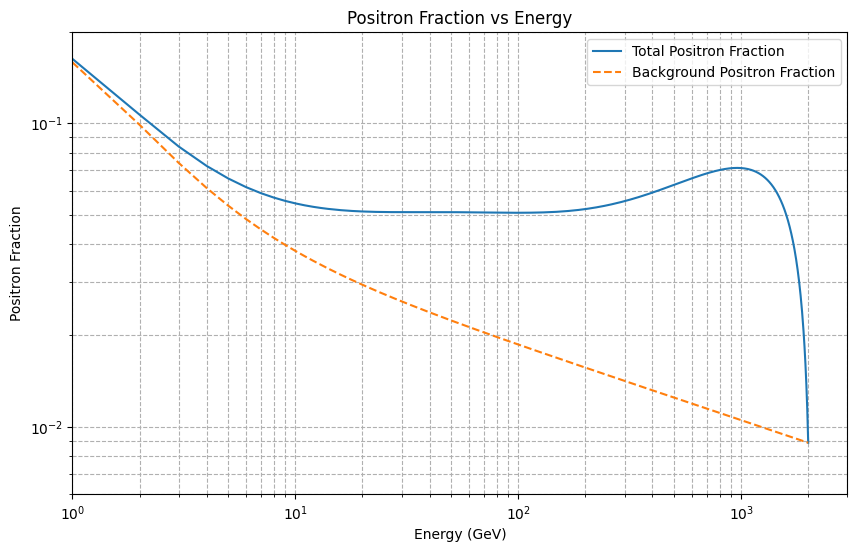

In [51]:
# Plotting Positron Fraction
plt.figure(figsize=(10, 6))
plt.loglog(E, positron_fraction, label='Total Positron Fraction')
plt.loglog(E, background_positron_fraction, linestyle='--', label='Background Positron Fraction')
plt.xlabel('Energy (GeV)')
plt.ylabel('Positron Fraction')
plt.title('Positron Fraction vs Energy')
plt.legend()
plt.grid(True, which="both", ls="--") #show grid
plt.xlim([1, 3000]) #as in the paper
plt.ylim([0.006, 0.2]) #as in the paper
plt.show()

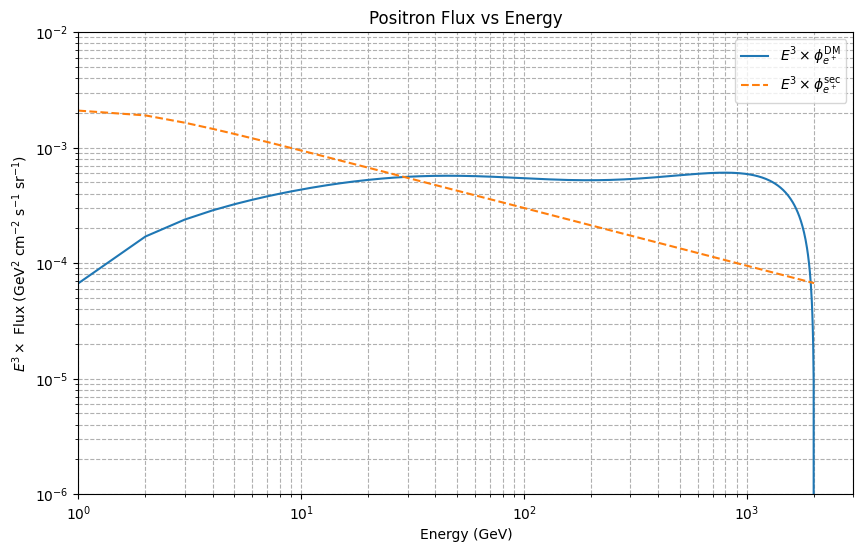

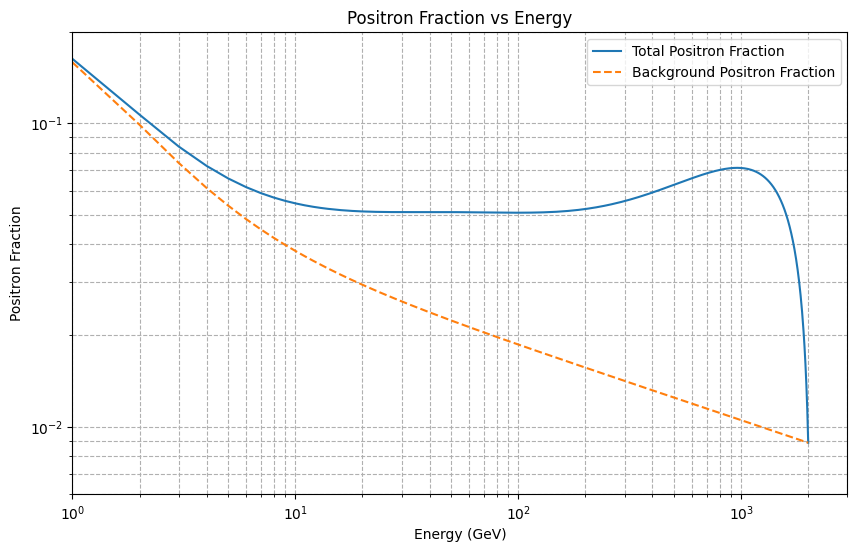

In [15]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

pi = np.pi
c = 3.0e10  # cm/s
fac = 3.08567758e21 #unit conversion 
# Parameters
K0 = 3e27
alpha = 0.6
C = 3.0 ** 0.6
tau = 1e16
L = 4.0 * fac  # cm
R = 20.0 * fac  # cm
mchi = 2000.0  # GeV
sigmaV_WW = 1.6e-23
sigmaV_ZZ = 3e-25
r_solar = 8.5 * fac  # cm
z_solar = 0.0 * fac # cm
N_r = 50 #r grid
N_z = 50 #z grid
N = 10
M = 10

# Fragmentation functions from the paper. Can add other fragmentation functions here as well especially for low m_chi
def f_WW(x):
    ln_x = np.log(x)
    WW = (
        -2.28838
        - 0.605364 * ln_x
        - 0.287614 * ln_x**2
        - 0.762714 * ln_x**3
        - 0.319561 * ln_x**4
        - 0.0583274 * ln_x**5
        - 0.00503555 * ln_x**6
        - 0.00016691 * ln_x**7
    )
    return np.exp(WW)

def f_ZZ(x):
    ln_x = np.log(x)
    ZZ = (
        -2.75588
        - 0.45725 * ln_x
        - 0.141373 * ln_x**2
        - 0.905392 * ln_x**3
        - 0.444098 * ln_x**4
        - 0.0936451 * ln_x**5
        - 0.00942148 * ln_x**6
        - 0.000369777 * ln_x**7
    )
    return np.exp(ZZ)

#f_WW(0.1)
#f_ZZ(0.1)

# Dark matter density profile as in the paper
def rho(r, z):
    Rc = 2.8 * fac #core radius of galaxy
    r_gc = np.sqrt(r * r + z * z) #distance from galactic center
    rho0 = 0.43 #local halo density
    num = Rc * Rc + r_solar * r_solar
    denom = Rc * Rc + r_gc * r_gc
    return rho0 * num / denom

# Preparing the zeros of Bessel function J0
zeta = sp.jn_zeros(0, N)

#zeta

# Preparing the z and r grids for midpoint integration 
dr = R / N_r
dz = 2 * L / N_z #since z from -L to L

r = []
for i in range(N_r):
    r_i = (i + 0.5) * dr
    r.append(r_i)
r = np.array(r)

z = []
for j in range(N_z):
    z_j = -L + (j + 0.5) * dz #starting from -L
    z.append(z_j)
z = np.array(z)

#dr
#dz
#r
#z

# Computing the Bessel and sine functions on the grid
J0_vals = np.zeros((N_r, N))
for i in range(N_r):
    for n in range(1, N + 1):  # Starting n from 1
        arg = zeta[n - 1] * r[i] / R  # zeta[n-1] to access the correct zero
        J0_vals[i, n - 1] = sp.j0(arg)  # Store in zero-based index (othersie we get errors)


sin_vals = np.zeros((N_z, M))
for j in range(N_z):
    for m in range(1, M + 1):  # Starting m from 1
        arg = m * pi * (z[j] - L) / (2 * L)  
        sin_vals[j, m - 1] = np.sin(arg)  # Store in zero-based index

#J0_vals
#sin_vals

# Computing the Dark matter number density on teh grid
rho_grid = np.zeros((N_r, N_z))
for i in range(N_r):
    for j in range(N_z):
        rho_grid[i, j] = rho(r[i], z[j])

n_chi_grid = rho_grid / mchi #divided by Dark matter mass

#n_chi_grid

# Energy grid after experimentation, we need more grid values for low energy range
epsilon_min = 1.0
epsilon_mid = 120.0 #more grid points between 1 and 120 GeV
epsilon_max = mchi

deltaE_low = 1 #space between grid points in the low energy region
N_eps_low = int((epsilon_mid - epsilon_min) / deltaE_low) + 1
N_eps_high = 200 #number of steps after 120 GeV
deltaE_high = (epsilon_max - epsilon_mid) / (N_eps_high - 1)

eps_low = []
for i in range(N_eps_low):
    eps_i = epsilon_min + i * deltaE_low
    eps_low.append(eps_i)

eps_high = []
for i in range(1, N_eps_high):
    eps_i = epsilon_mid + i * deltaE_high
    eps_high.append(eps_i)

E = np.array(eps_low + eps_high) #energy grid combining low and high ranges

#E

# Positron production spectrum
def dN_dE(eps):
    x = eps / mchi
    if x <= 0 or x >= 1:
        return 0.0
    dNdx_WW = sigmaV_WW * f_WW(x) #multiplied by \simga*v, will change location later
    dNdx_ZZ = sigmaV_ZZ * f_ZZ(x) #multiplied by \simga*v, will change location later
    return (dNdx_WW + dNdx_ZZ) / mchi  # divided by DM mass

#dN_dE(2)

# Q_mn(epsilon). This takes a few minutes. Might change method later or replace for loops to make faster.
Qmn = np.zeros((len(E), M, N))
for k in range(len(E)):
    eps = E[k]
    dNdE = dN_dE(eps)
    for n in range(1, N + 1):
        J1_zeta_n = sp.j1(zeta[n - 1])
        norm = 2.0 / (J1_zeta_n * J1_zeta_n * R * R * L)
        for m in range(1, M + 1):
            integrand = np.zeros((N_r, N_z)) #Here I use the midpoint method for integration on the r and z grid
            for i in range(N_r):
                for j in range(N_z):
                    J0 = J0_vals[i, n - 1]
                    sin_m = sin_vals[j, m - 1]
                    n_chi_sq = n_chi_grid[i, j] * n_chi_grid[i, j]
                    integrand[i, j] = 0.5 * n_chi_sq * dNdE * J0 * sin_m * r[i] #later I will bring \sigma*v here and sum. now they are inside dN_dE.
            integral = np.sum(integrand) * dr * dz
            Qmn[k, m - 1, n - 1] = integral * norm

#Q[2, 5, 5]
#Qmn

# A_mn(epsilon) 
Amn = np.zeros((len(E), M, N))
for i in range(len(E)):
    eps = E[i]
    eps_sq = eps * eps
    for n in range(1, N + 1):
        for m in range(1, M + 1):
            eps_p = E[i:] #starting from grid points where eps_p > eps 
            Qmn_p = Qmn[i:, m - 1, n - 1] #bringing corresponding values 
            kappa = (zeta[n - 1] / R) ** 2 + (m * pi / (2 * L)) ** 2
            Lambda = kappa * K0 * tau * (
                -C * (1.0 / eps - 1.0 / eps_p)
                + (eps ** (alpha - 1) - eps_p ** (alpha - 1)) / (alpha - 1)
            )
            integrand = (tau * Qmn_p / eps_sq) * np.exp(Lambda)
            integral = np.trapz(integrand, eps_p) #here I use the Trapezoidal method for integration on E grid
            Amn[i, m - 1, n - 1] = integral

#Amn

# Positron distribution at Earth
f_ep = []
for i in range(len(E)):
    s = 0.0
    for n in range(1, N + 1):
        J0_val = sp.j0(zeta[n - 1] * r_solar / R)
        for m in range(1, M + 1):
            sin_val = np.sin(m * pi * (z_solar - L) / (2 * L)) 
            s += Amn[i, m - 1, n - 1] * J0_val * sin_val
    f_ep.append(s)

f_ep = np.array(f_ep)
phi_e_plus_signal = (c / (4.0 * pi)) * f_ep

#f_ep
#phi_e_plus_signal

# Background fluxes from the paper
def phi_e_minus_prim(E):
    return 0.16 * E ** (-1.1) / (1.0 + 11.0 * E ** 0.9 + 3.2 * E ** 2.15)

def phi_e_minus_sec(E):
    return 0.70 * E ** 0.7 / (1.0 + 110.0 * E ** 1.5 + 600.0 * E ** 2.9 + 580.0 * E ** 4.2)

def phi_e_plus_sec(E):
    return 4.5 * E ** 0.7 / (1.0 + 650.0 * E ** 2.3 + 1500.0 * E ** 4.2)

phi_e_plus_sec_array = phi_e_plus_sec(E)
phi_e_minus_prim_array = phi_e_minus_prim(E)
phi_e_minus_sec_array = phi_e_minus_sec(E)


# Total positron and electron fluxes
phi_e_plus_total = phi_e_plus_signal + phi_e_plus_sec_array
phi_e_minus_total = phi_e_minus_prim_array + phi_e_minus_sec_array

# Positron fraction
positron_fraction = phi_e_plus_total / (phi_e_plus_total + phi_e_minus_total)

# Plotting E^3 * Flux
plt.figure(figsize=(10, 6))
plt.loglog(E, E ** 3 * phi_e_plus_signal, label=r'$E^3 \times \phi_{e^+}^{\text{DM}}$')
plt.loglog(E, E ** 3 * phi_e_plus_sec_array, linestyle='--', label=r'$E^3 \times \phi_{e^+}^{\text{sec}}$')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^3 \times$ Flux (GeV$^{2}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.title('Positron Flux vs Energy')
plt.legend()
plt.grid(True, which="both", ls="--") #show grid
plt.xlim([1, 3000]) #as in the paper
plt.ylim([1e-6, 1e-2]) #as in the paper
plt.show()

# Background positron fraction
phi_e_plus_background = phi_e_plus_sec_array
phi_e_minus_background = phi_e_minus_prim_array + phi_e_minus_sec_array
phi_e_total_background = phi_e_plus_background + phi_e_minus_background
background_positron_fraction = phi_e_plus_background / phi_e_total_background

# Plotting Positron Fraction
plt.figure(figsize=(10, 6))
plt.loglog(E, positron_fraction, label='Total Positron Fraction')
plt.loglog(E, background_positron_fraction, linestyle='--', label='Background Positron Fraction')
plt.xlabel('Energy (GeV)')
plt.ylabel('Positron Fraction')
plt.title('Positron Fraction vs Energy')
plt.legend()
plt.grid(True, which="both", ls="--") #show grid
plt.xlim([1, 3000]) #as in the paper
plt.ylim([0.006, 0.2]) #as in the paper
plt.show()